# Atmosphere Simulation

Sayers+2010

https://iopscience.iop.org/article/10.1088/0004-637X/708/2/1674/pdf

\begin{align}
P(\vec{\alpha})&=B_\nu^2(sin\epsilon)^{(1-b)}\left | \vec{\alpha} \right |^{-b}\\\\
\alpha&: {\rm 2D\,\, angular\,\, frequency\,\, [1/rad]}\\
b&=11/3\\
\epsilon&: {\rm elevation}\\
B_\nu^2&: {\rm power\,\, spectrum\,\, amplitude\,\, [mK^2/rad^{-5/3}]}
\end{align}
<br><br>

\begin{align}
\epsilon_\nu &= 1-T = 1-e^{-\tau_\nu}\\
\epsilon_\nu&: {\rm emissivity}\\
\tau_\nu&: {\rm opacity}\\
T&: {\rm transmission}
\end{align}
<br>
\begin{align}
B_\nu^2 &= A(\delta\epsilon_\tau)^2B_{\rm atm}^2\\
&=A(\delta T)^2B_{\rm atm}^2\\
&=A\left ( \frac{\delta T}{\delta C_{\rm PWV}} \right )^2\delta C_{\rm PWV}^2B_{\rm atm}^2\\
&=A\left ( \frac{\delta T}{\delta C_{\rm PWV}} \right )^2\left ( \frac{\delta C_{\rm PWV}}{C_{\rm PWV}} \right )^2 C_{\rm PWV}^2\left (  \frac{2\nu^2}{c^2}k_BT_{\rm atm}\right)^2\\
&=\left [  A\left ( \frac{\delta C_{\rm PWV}}{C_{\rm PWV}} \right )^2\right ]\left ( \frac{\delta T}{\delta C_{\rm PWV}} \right )^2 C_{\rm PWV}^2 \nu^4T_{\rm atm}^2\\\\
\end{align}


Data: (Sayers+2010) median $B_\nu^2=4000\,mK^2rad^{-5/3}$, $\nu=268$ GHz, $C_{\rm PWV}=1.68$ mm @ Mauna Kea<br>
$\left [  A\left ( \frac{\delta C_{\rm PWV}}{C_{\rm PWV}} \right )^2\right ]$: Since MK is \~2x of South Pole, asuume KP is 2x of MK<br>
$\left ( \frac{\delta T}{\delta C_{\rm PWV}} \right )^2$: Use the data from "CSO Atmospheric Transmission Interactive Plotter" to calculate nemerically<br>
$C_{\rm PWV}$: use 5 mm for KP<br>
$T_{\rm atm}$: assume KP is the same as MK (250~260 K)

***
# Calculate $B_\nu^2(\nu)$ model for Kitt Peak

(500.0, 500000.0)

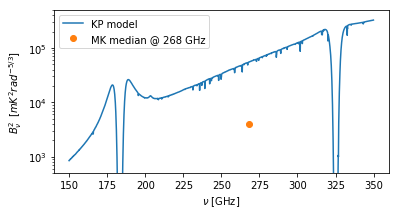

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mauna Kea data from Sayers+10
nu_calnu = 268 # GHz
Cpwv_mk = 1.68 # mm
Bnu2mk_calnu = 4000 # mK^2 rad^{-5/3}
Tatm_mk = 260 # K

# Assumption for Kitt Peak
Cpwv_kp = 5 # mm
dC_C_scale = np.sqrt(2)
Tatm_kp = 260

# load the table for dT/dCpwv
datadir = '../CSO_atm/'
Tdf = pd.read_csv(datadir + 'T_CSO.csv')
dTdCdf = pd.read_csv(datadir + 'dTCpwv_CSO.csv')
nu_arr = Tdf['freq'].values

# scale MK data to KP
dTdCmk_calcnu = dTdCdf[dTdCdf['freq']==nu_calnu]['%.2f'%Cpwv_mk].values[0]
norm = Bnu2mk_calnu / dTdCmk_calcnu**2 / Cpwv_mk**2 / nu_calnu**4 / Tatm_mk**2

dTdCkp_calcnu = dTdCdf['%.2f'%Cpwv_kp].values
Bnu2kp_arr = norm * dC_C_scale**2 * dTdCkp_calcnu**2 * Cpwv_kp**2 * nu_arr**4 * Tatm_kp**2

# Plot the results
plt.figure(figsize=(6,3))
plt.semilogy(nu_arr, Bnu2kp_arr, label = 'KP model')
plt.semilogy(nu_calnu, Bnu2mk_calnu, 'o', label = 'MK median @ {} GHz'.format(nu_calnu))
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$B_{\nu}^2\,\,\,[mK^2 rad^{-5/3}]$')
plt.legend(loc=2)
plt.ylim([5e2,5e5])

"Bnu2kp_arr" is the $B_\nu^2(\nu)$ model for KP at frequencies "nu_arr"

***
# Generate Spatial Fluctuations

Generate a Gaussian random 2D map with power spectrum:
\begin{equation}
P(\vec{\alpha})=(sin\epsilon)^{(1-b)}\left | \vec{\alpha} \right |^{-b}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.units as u
from scipy import signal
from scipy.ndimage import gaussian_filter

def map2D_from_PS1D(PS1D, k_vec, Nx, Ny, dx, dy):
    kx_vec = np.fft.fftfreq(Nx) / dx
    ky_vec = np.fft.fftfreq(Ny) / dy
    kxx,kyy = np.meshgrid(kx_vec,ky_vec)
    kxx = np.swapaxes(kxx,0,1)
    kyy = np.swapaxes(kyy,0,1)
    k_arr = np.sqrt(kxx**2 + kyy**2)
    P_arr = np.interp(k_arr,k_vec,PS1D)
    P_arr[k_arr==0] = 0
    V = Nx * Ny * dx * dy

    real_part = np.random.normal(size=k_arr.shape)
    im_part = np.random.normal(size=k_arr.shape)

    ft_map = (real_part + im_part*1.0j) * np.sqrt(abs(P_arr * V)) / dx / dy
    map2D = np.fft.ifftn(ft_map)
    map2D = np.real(map2D)
    return map2D

def timestream_from_PSD(PSDfunc, fs, dt, Tint, fcut=np.inf, return_PSD=False):
    N = int(Tint/dt)
    f_arr = np.fft.fftfreq(N)/dt
    re_part = np.random.normal(size=f_arr.shape)
    im_part = np.random.normal(size=f_arr.shape)
    PSD = np.zeros_like(f_arr)
    PSD[f_arr!=0] = PSDfunc(np.abs(f_arr[f_arr!=0]))
    PSD[np.abs(f_arr)>fcut] = 0

    ts_complex = (re_part + im_part*1.0j) * np.sqrt(abs(PSD * Tint))/dt
    ts_arr = np.real(np.fft.ifftn(ts_complex))
    t_arr = np.arange(0,dt*len(ts_arr), dt)

    if return_PSD:
        f_arr, PSD_arr = signal.welch(ts_arr, fs, nperseg=N)
        PSDin_arr = np.zeros_like(PSD_arr)
        PSDin_arr[f_arr!=0] = PSDfunc(np.abs(f_arr[f_arr!=0]))
        PSDin_arr[np.abs(f_arr)>fcut] = 0

        return t_arr, ts_arr, f_arr, PSD_arr, PSDin_arr
    
    return t_arr, ts_arr


def PSD_from_ts(ts_arr, fs=150):
    '''
    fs: sampling freq [Hz]
    '''
    f_arr, PSD_arr = signal.welch(ts_arr, fs, nperseg=len(ts_arr))
    return f_arr, PSD_arr

In [56]:
import astropy.units as u
from scipy.ndimage import gaussian_filter

# ========== define parameters ============
b = 11. / 3.
el = np.pi / 2 # elevation, pi/2 for zenith
map_size_x = 60 * u.deg
map_size_y = 60 * u.deg
downsamp = 3 # downsampling the map resolution

v_wind = 30 * u.arcmin / u.second # wind speed
v_scan = 5 * u.arcmin / u.second # scanning speed
fs = 150 * u.Hz # TIME time stream
PSF = 0.5 *u.arcmin # TIME PSF size (for smoothing the map)
# =============================================

# define the map size and resolution
dx_map = ((v_wind-v_scan) / fs).to(u.rad)
dx_map *= downsamp
dy_map = dx_map
Nx_map = int((map_size_x // dx_map).decompose())
Ny_map = int((map_size_y // dy_map).decompose())

# build the 1D power spectrum
kmin, kmax = 1 / (dx_map.value*Nx_map), 1 / dx_map.value
k_vec = np.logspace(np.log10(kmin/2), np.log10(kmax*2), 1000)
PS1D = (np.sin(el))**(1-b) * k_vec**-b

# generate 2D map from the 1D power spectrum
map2D = map2D_from_PS1D(PS1D, k_vec, Nx_map, Ny_map, dx_map, dy_map)

# smooth the map with PSF
PSF_pix = PSF.to(u.rad).value / dx_map
map2D_sm = gaussian_filter(map2D, sigma = PSF_pix)

map2D is the simulated atmosphere map with dimension (Nx_map, Ny_map), pixel size (dx_map, dy_map)

map2D_sm is the map2D smoothed with PSF sized Gaussian kenel

## plot some time-streams and their power spectrum (optional)

Consider 1 degree scan with 150 Hz sampling frequency and 5 arcmin/sec scanning speed, which give 12 sec integration time

(0.08, 5.0)

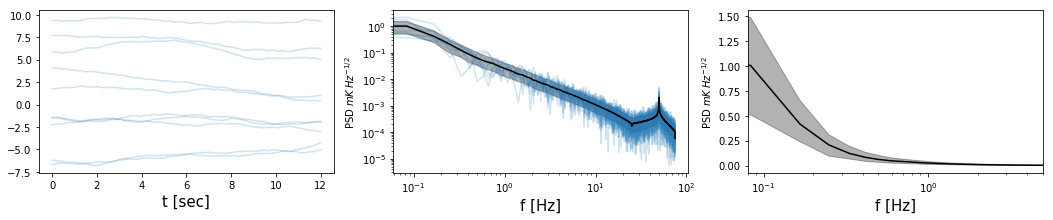

In [73]:
dx_samp = 1./downsamp # sampling size in pixel unit
fov_scan = 1 * u.deg
t_scan = fov_scan / v_scan
Nsamp = (t_scan * fs).decompose().value

x_start = round((Nx_map - dx_samp * Nsamp)/2)
x_samp = np.arange(x_start,x_start + dx_samp * Nsamp, dx_samp)
x_samp = np.round(x_samp).astype(int)
x_samp = x_samp[x_samp < Nx_map]
Nsamp = len(x_samp)

fig, ax = plt.subplots(1,3, figsize=(18,3))
t_arr = np.arange(Nsamp)/fs
PSD_all = []
for y in range(Ny_map):
    ts_arr = map2D_sm[x_samp,y]
    f_arr, PSD_arr = PSD_from_ts(ts_arr)
    PSD_arr = np.sqrt(PSD_arr)
    PSD_all.append(PSD_arr)
    if y in np.arange(0,Ny_map,Ny_map//10):
        ax[0].plot(t_arr, ts_arr, 'C0', alpha=0.2)
        ax[1].loglog(f_arr, PSD_arr, 'C0', alpha=0.2)
PSD_all = np.array(PSD_all)
ax[1].loglog(f_arr, np.median(PSD_all, axis=0),'k')
ax[1].fill_between(f_arr, np.percentile(PSD_all, 16, axis=0),np.percentile(PSD_all, 84, axis=0),
                   color='k',alpha=0.3)

ax[2].semilogx(f_arr, np.median(PSD_all, axis=0),'k')
ax[2].fill_between(f_arr, np.percentile(PSD_all, 16, axis=0),np.percentile(PSD_all, 84, axis=0),
                   color='k',alpha=0.3)

ax[0].set_xlabel('t [sec]', fontsize=15)
ax[1].set_ylabel(r'PSD $mK\,Hz^{-1/2}$',fontsize=10)
ax[1].set_xlabel('f [Hz]', fontsize=15)
ax[2].set_ylabel(r'PSD $mK\,Hz^{-1/2}$',fontsize=10)
ax[2].set_xlabel('f [Hz]', fontsize=15)
ax[2].set_xlim([8e-2,5e0])